In [ ]:
# This script will read the html code from NEP-Fitters webpage and extract
# out the PSF-FWHM as well as the other values and their errors into a
# structure. Then it will perform a Wilcoxon rank sum test and output the
# statistics and histograms comparing populations

# Change values of Parameters/variables
# Input: html files
    # Data is organized that each html file contains both the outer and inner tubule results, in that order.
    # The script will separate them based on the number of datapoints and the number of datasets or 'set1'.
    # It assumes that there is an even number of outer and inner tubules, so make sure that is the case
# Output: 
#     - png file of histogram
#     - pickled .npy file containing stats info from Wilcoxon rank sum statistics

In [62]:
# Parameters 
import numpy as np
import os
# #Perinuclear vs peripheral
# savedir = "K:\\SP8\\Inner_vs_Outer_Diameter_analysis\\20221102_Analysis_Results"
# d2name = 'Perinuclear'                   # Name of first dataset
# d1name = 'Peripheral'           # Name of second dataset
# d1plot = 'Perinuclear'                 # Name of dataset on plot
# d2plot = 'Peripheral'         # Name of dataset on plot
# ddir = "K:\\SP8\\Inner_vs_Outer_Diameter_analysis\\All_html"  # File path to folder with saved data
# color = [1, 6]
# # Histogram adjustments
# xm1 = -55                           # x coordinate of d1 mean
# ym1 = -0.3                             # y coordinate of d1 mean
# xm2 = 2                             # x coordinate of d2 mean
# ym2 = -0.3                           # y coordinate of d2 mean
# xp = -60                           # x coordinate of p-value text
# yp = -5                             # y coordinate of p-value text
# legloc = 'upper right'
# yticks = [0, 3, 6, 9, 12]
# ybot = 0
# ytop = 13.5
# set1 = 9
# KO = 0


#Rtn4 vs Rtn4 KO
savedir = "K:\\SP8\\WT-U2OS_vs_Rtn4KO\\Analysis-U2OS-Halo-Sec61B_Vs_Rtn4KO-Halo-Sec61B\\Analysis_triplicate_V3"
d1name = 'U2OS'                   # First part of file Name of first dataset
d2name = 'U2OS-Rtn4-KO'           # First part of file Name of second dataset
d1plot = 'U-2 OS'                 # Name of dataset on plot
d2plot = 'U-2 OS\nRtn4-KO'         # Name of dataset on plot
ddir = "K:\\SP8\WT-U2OS_vs_Rtn4KO\\Analysis-U2OS-Halo-Sec61B_Vs_Rtn4KO-Halo-Sec61B\\nep_html_files"
color = [7, 0]
# Histogram adjustments
xm1 = 5                           # x coordinate of d1 mean
ym1 = -5                             # y coordinate of d1 mean
xm2 = -55                         # x coordinate of d2 mean
ym2 = -5                           # y coordinate of d2 mean
xp = -60                           # x coordinate of p-value text
yp = -5                             # y coordinate of p-value text
legloc = 'upper right'
yticks = [0, 20, 40, 60]
ybot = 0
ytop = 60
set1 = 18                          # of files for first set of data (how many cells)
KO = 1

# Adjust these variables
#set1 = 9                           # # of files for first set of data (how many cells)
#set2 = 2                           # # of files for second set of data (how many cells)
diathresh = 30.                     # diameters above this threshold are permissible
errthresh = 25.                     # errors below this threshold are permissible
ver = "_V3"

# create list of files in data folder
d_list = []
for path in os.listdir(ddir):
    # check if current path is a file
    if os.path.isfile(os.path.join(ddir, path)):
        d_list.append(path)

# don't touch
d1_list = np.zeros(set1,dtype=list)
for a in range(set1):
    d1_list[a] = ddir + '\\' + d_list[a]

In [2]:
import codecs
import re

# Function to remove outliers from data
def filter_outliers(data):
    '''
    -----
    Input
    -----
        data: (N,) numpy array of floats
            array to filter out outliers
            
    ------
    Output
    ------
        filt_data: (N-# of outliers,) numpy array of floats
            'data' with outliers removed
    '''
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])
 
    # compute IRQ
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    low_inds = data > lower_bound
    high_inds = data < upper_bound
    inds = low_inds * high_inds
    filt_data = data[inds]
    #outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
 
    return filt_data, inds

def nep_reader(data_list):
    '''
    Read .html file output from NEP-Fitting analysis in PYME. Extract measurements and their erros and output in a 
    dictionary 'output'. Note: this code only works because the .html file output from NEP Fitting is consistent. It
    doesn't parse the .html in a sophisticated way (ie. its gross but it gets the job done).
    
    -----
    Input
    -----
        data_list: list of strings
            Each value in the list is a pathway string for an .html file to be read and data extracted
            
    ------
    Output
    ------
        output: dictionary
            contains keys for each type of measurement output from NEP-Fitting and their errors (N: # of datapoints from 
            dataset1)
                Keys:
                    'amplitude'
                        N x 1 array of amplitude measurements
                        
                    'amplitude-error'
                        N x 1 array of amplitude errors
                        
                    'diameter'
                        N x 1 array of diameter measurements
                        
                    'diameter-error'
                        N x 1 array of diameter errors
                        
                    'center'
                        N x 1 array of center measurements
                        
                    'center-error'
                        N x 1 array of center errors
                        
                    'background'
                        N x 1 array of background measurements
                    
                    'background-error'
                        N x 1 array of background errors
    '''
    print(set1)
    dpoints = 0
    # Loop to determine how many data points there will be total for array initialization
    for j in range(len(data_list)):
        jr = codecs.open(data_list[j],'r','utf-8')
        jread = jr.read()
        last_j = str.rfind(jread,'plusmn')
        points_test = jread[last_j-330:last_j-323]
        dpoints = dpoints + int(re.sub('[^0-9.]','',points_test)) + 1
    
    # initialize arrays
    d1_amp_all = np.zeros(dpoints,dtype=list)
    d1_amp_err = np.zeros(dpoints,dtype=list)
    d1_diam_all = np.zeros(dpoints,dtype=list)
    d1_diam_err = np.zeros(dpoints,dtype=list)
    d1_cent_all = np.zeros(dpoints,dtype=list)
    d1_cent_err = np.zeros(dpoints,dtype=list)
    d1_bg_all = np.zeros(dpoints,dtype=list)
    d1_bg_err = np.zeros(dpoints,dtype=list)
    count = 0
    for c in range(len(data_list)):
        f=codecs.open(data_list[c],'r','utf-8')
        fread = f.read()
        last_p = str.rfind(fread,'plusmn')
        d_test = fread[last_p-330:last_p-323]
        d_num = int(re.sub('[^0-9.]','',points_test))

        if c <= set1:
            for d in range(d_num+2):
                if d == 0:
                    ind = str.find(fread,'plusmn')
                    avg_test = fread[ind-8:ind-2]
                    # remove non-numericals
                    if not avg_test.isnumeric():
                        for e in range(len(avg_test)):
                            if avg_test[e].isnumeric():
                                d1_avg = np.float64(avg_test[e:])
                                break
                    else:
                        d1_avg = float(avg_test)
                    fread2 = fread[ind+10:]
                else:
                    # find amplitude and filter out non-numericals
                    ind1 = str.find(fread2,'plusmn')
                    amp_test = fread2[ind1-8:ind1-2]
                    d1_amp_all[count] = np.float64(re.sub('[^0-9.]','',amp_test))
                    amp_err = fread2[ind1+6:ind1+13]
                    d1_amp_err[count] = np.float64(re.sub('[^0-9.]','',amp_err))
                    fread2 = fread2[ind1+10:]
                    
                    # find diameter and filter out non-numericals
                    ind2 = str.find(fread2,'plusmn')
                    diam_test = fread2[ind2-8:ind2-2]
                    d1_diam_all[count] = np.float64(re.sub('[^0-9.]','',diam_test))
                    diam_err = fread2[ind2+6:ind2+13]
                    d1_diam_err[count] = np.float64(re.sub('[^0-9.]','',diam_err))
                    fread2 = fread2[ind2+10:]
                    
                    # find center and filter out non-numericals
                    ind3 = str.find(fread2,'plusmn')
                    cent_test = fread2[ind3-8:ind3-2]
                    d1_cent_all[count] = np.float64(re.sub('[^0-9.]','',cent_test))
                    cent_err = fread2[ind3+6:ind3+13]
                    d1_cent_err[count] = np.float64(re.sub('[^0-9.]','',cent_err))
                    fread2 = fread2[ind3+10:]
                    
                    # find background and filter out non-numericals
                    ind4 = str.find(fread2,'plusmn')
                    bg_test = fread2[ind4-7:ind4-2]
                    d1_bg_all[count] = np.float64(re.sub('[^0-9.]','',bg_test))
                    bg_err = fread2[ind4+6:ind4+13]
                    d1_bg_err[count] = np.float64(re.sub('[^0-9.]','',bg_err))
                    fread2 = fread2[ind4+10:]
                    count = count + 1
                      
    output = {'amplitude': d1_amp_all,'amplitude-error': d1_amp_err, 
              'diameter': d1_diam_all, 'diameter-error': d1_diam_err,
              'center': d1_cent_all, 'center-error': d1_cent_err, 
              'background':d1_bg_all, 'background-error': d1_bg_err}

    return output

In [3]:
# Read NEP Fitter html files and extract information
d1_output = nep_reader(d1_list)

18


In [17]:
if KO == 0:
    # Create filters to get out only the outer or inner datapoints
    plen = len(d1_output['amplitude']) #determine total number of datapoints
    # batch assumes that there is an even number of datapoints from each cell for each set (ex: 10 inner tubules and 10 outer tubules)
    batch = int(plen/set1/2) #determine how many datapoints from each cell belong to set1 or set2
    # Function that creates a list of indices based on batch (ex: 0-9, skip 10-19, 20-29, skip 30-39, etc)
    def gen(x):
        while x + 10 <= plen:
            yield list(range(x,x+10))#(tuple(range(x,x+10)))
            x += batch*2
    # Create lists for outer tubules and inner tubules and flatten them
    outer_bool_filt = list(gen(x=0))
    outer_bool_flat = [item for sublist in outer_bool_filt for item in sublist]
    inner_bool_filt = list(gen(x=10))
    inner_bool_flat = [item for sublist in inner_bool_filt for item in sublist]
elif KO == 1:
    plen = int(len(d1_output['amplitude'])/2) #determine total number of datapoints
    #out_bool_flat = d1_output['diameter']

In [21]:
# Use index lists to extract out tubule measurements from each set (ex: outer and inner tubules)
if KO == 0:
    diam_outer = d1_output['diameter'][outer_bool_flat]
    diam_inner = d1_output['diameter'][inner_bool_flat]
    err_outer = d1_output['diameter-error'][outer_bool_flat]
    err_inner = d1_output['diameter-error'][inner_bool_flat]
elif KO == 1:
    diam_outer = d1_output['diameter'][0:plen] # KO
    diam_inner = d1_output['diameter'][plen:] # WT
    err_outer = d1_output['diameter-error'][0:plen] # KO
    err_inner = d1_output['diameter-error'][plen:] # WT

In [22]:
# apply error and diameter thresholds
diam_filt_outer = diam_outer >= diathresh
err_filt_outer = err_outer <= errthresh
diam_filt_inner = diam_inner >= diathresh
err_filt_inner = err_outer <= errthresh
filt_outer = diam_filt_outer*err_filt_outer
filt_inner = diam_filt_inner*err_filt_inner
diam_outer = diam_outer[filt_outer]
diam_inner = diam_inner[filt_inner]
err_outer = err_outer[filt_outer]
err_inner = err_inner[filt_inner]

In [23]:
# Wilcoxon rank sum statistical test and save to pickled .npy file
from scipy.stats import ranksums
stats = ranksums(diam_outer,diam_inner)
save_stats = savedir + '\\' + d1name +'_vs_' + d2name + ver + '.npy'
np.save(save_stats, stats, allow_pickle=True)
stats

RanksumsResult(statistic=10.631398691007274, pvalue=2.1289532345630746e-26)

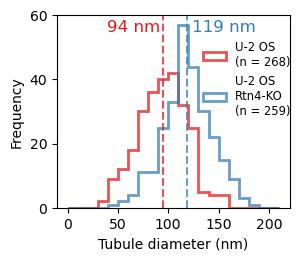

In [64]:
# Graph for Inner vs Outer tubules

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

d_max = np.max([np.max(diam_outer),np.max(diam_inner)])
roundmax = np.around(d_max,-1)
bins = np.arange(0,220,10)
d1_mean = np.average(diam_outer,axis=0)
d2_mean = np.average(diam_inner,axis=0)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10}) #32
plt.rcParams.update({'legend.frameon': False})
fig = plt.figure(figsize=[3,2.5])

n1, bins1, patches1 = plt.hist(x=diam_inner,bins=bins, alpha=0.75, rwidth=1, density=False, color=CB_color_cycle[color[0]],
                              label=d1plot + '\n(n = ' + str(len(diam_outer)) + ')',
                               edgecolor=CB_color_cycle[color[0]],range=(0,200), histtype='step', linewidth=2)
n2, bins2, patches2 = plt.hist(x=diam_outer,bins=bins, alpha=0.75, rwidth=1, density=False, color=CB_color_cycle[color[1]],
                              label=d2plot + '\n(n = ' + str(len(diam_inner)) + ')',
                               edgecolor=CB_color_cycle[color[1]],range=(0,200),histtype='step', linewidth=2)

plt.ylim(bottom=ybot,top=ytop)
plt.yticks(yticks)
# Add dashed line at average value for d1
plt.axvline(x=d1_mean, linestyle='--',color=CB_color_cycle[color[1]],alpha=0.75)

# Add average value as text on plot near top of average line for d1
plt.text(d1_mean+xm1,np.max([n1,n2])+(np.max([n1,n2])/20)+ym1,str(int(np.rint(d1_mean)))+' nm',color=CB_color_cycle[color[1]], fontsize='large')

# Add dashed line at average value for d2
plt.axvline(x=d2_mean, linestyle='--',color=CB_color_cycle[color[0]],alpha=0.75)

# Add average value as text on plot near top of average line for d2
plt.text(d2_mean+xm2,np.max([n1,n2])+(np.max([n1,n2])/20)+ym2,str(int(np.rint(d2_mean)))+' nm',color=CB_color_cycle[color[0]], fontsize='large')

# Add p-value text onto plot
#plt.text(roundmax+xp,np.max([n1,n2])+yp,'p = ' + str(np.format_float_scientific(stats[1], precision=2)), fontsize='large')

plt.xlabel('Tubule diameter (nm)')
plt.ylabel('Frequency')
plt.legend(loc=legloc,framealpha=0.25, bbox_to_anchor=(1.05,0.92),fontsize = 'small')

hist_save = savedir + '\\' + d1name +'_vs_' + d2name + ver + '.png'
plt.savefig(hist_save, dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=0.05,
        metadata=None)

plt.show()
plt.close()

In [31]:
# class Parse(HTMLParser):
#     def __init__(self):
#     #Since Python 3, we need to call the __init__() function 
#     #of the parent class
#         super().__init__()
#         self.reset()
 
#     #Defining what the methods should output when called by HTMLParser.
#     def handle_starttag(self, tag, attrs):
#         print("Start tag: ", tag)
#         for a in attrs:
#             print("Attributes of the tag: ", a)
 
#     def handle_data(self, data):
#         print("Here's the data: ", data)
#         return data
 
#     def handle_endtag(self, tag):
#         print("End tag: ", tag)
 
 
# testParser = Parse()
# poop = testParser.feed(fread)

In [ ]:
ddir